# QBS 108 Machine Learning Assignment 4
## Applied Deep Learning
### 1 CNN for Fish Species Classification
Note: data is from the Kaggle Nature Conservancy Fisheries Monitoring challenge (https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring)

#### 1.1 Model Training
##### 1.1.1 Tasks

In [63]:
# reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets,models,transforms,utils
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import OrderedDict
from PIL import Image
import pandas as pd

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [0]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "Part1_images"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 3

In [40]:
os.getcwd()

'/content/gdrive/My Drive/QBS108_hw4'

In [43]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
os.chdir('/content/gdrive/My Drive/QBS108_hw4/')

In [42]:
!ls

 Part1_images  'Part 2 Data'   QBS08_hw4.ipynb


(a) Training a Resnet18 model from scratch:

Below is the code that shows how to run the resnet18 model from scratch, but using the functions that were built later.
I will not run the code here, since the functions that were built below won't run. The defined functions include ``initialize_model``and ``train_model``.

Initialize the scratch version of the model: specifically, when we apply the scratch version, we set the paramter ``feature_extract = False``, and ``use_pretained = False``.

``scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=LR, momentum=Mom)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))``

(b) Fine-tuning all layers of the ImageNet pre-trained Resnet18 model:

Similarly, will not run the sample below:

Initialize the fine-tuning version of the model: specifically, when we apply the fine tuning pretrained version, we set the paramter ``feature_extract = False``, and ``use_pretained = True``.

``finetuning_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
finetuning_model = scratch_model.to(device)
finetuning_optimizer = optim.SGD(finetuning_model.parameters(), lr=LR, momentum=Mom)
finetuning_criterion = nn.CrossEntropyLoss()
_,finetuning_hist = train_model(finetuning_model, dataloaders_dict, finetuning_criterion, finetuning_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))``

(c) Using the ImageNet pre-trained Resnet18 model as a fixed feature extractor:

Similarly, will not run the sample below:

Initialize the feature-extraction version of the model: specifically, when we apply the feature extraction version, we set the paramter ``feature_extract = True``, and ``use_pretained = True``.

``fe_model,_ = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)
fe_model = scratch_model.to(device)
fe_optimizer = optim.SGD(fe_model.parameters(), lr=LR, momentum=Mom)
fe_criterion = nn.CrossEntropyLoss()
_,fe_hist = train_model(fe_model, dataloaders_dict, fe_criterion, fe_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))``

##### Before looking at the result, can you speculate how the training will be different among these three ways? Which way do you think is the most appropriate given this specific fishing dataset, and why?

As mentioned above, for a resnet18 model from scratch, we don't use the pre-trained model and set feature_extract to false; for a fine-tuning pretrained resnet18 model, we ues the pre-trained model but set feature_extract to false; for a feature-extraction pretrained resnet18 model, we use the pretrained model and set feature_extract to true. The "feature_extract" here refers to the step of setting Model Parameters’ ``.requires_grad`` attribute, which sets the ``.requires_grad`` attribute of the parameters in the model to True by default. 

When feature extracting, we only want to update the parameters of the last layer, and we do not need to compute the gradients of the parameters that we are not changing, so for efficiency we set the ``.requires_grad`` attribute to False. In other words, if ``feature_extract=True``, we manually set all of the parameter’s ``.requires_grad`` attributes to False by running the defined ``set_parameter_requires_grad`` function. When we are finetuning we can leave all of the ``.required_grad``’s set to the default of True.


Here, finetuning is the most appropariate given the fishing dataset. Noted that scratch is always the least accurate approach compared to the other two. Feature extraction is ideally used when the data we are trying to train the model on is similar to the data the pre-trained model was originally trained on and the size of our dataset is small. Since our fishing dataset is a large dataset and similar to the imagenet dataset, we choose fine tuning pretrained model.

##### 1.1.2 Model Training/Fine-tuning:
Initialize model: 

In [0]:
# initiate num_epochs and other parameters. Will be changed later accordingly
# def train_model(model, dataloaders, criterion, scheduler, optimizer, num_epochs=25, is_inception=False)
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False): 
    since = time.time()

    val_acc_history = []
    #loss_train = []
    #loss_val = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            #if phase == 'train':
            #   loss_train.append(epoch_loss)
            #if phase == 'val':
            #   loss_val.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history#, loss_train, loss_val

The code below is to help switch between the feature extraction mode and scratch/pretrained-fine-tuning mode. ``.requires_grad``=True for fine-tuning and scratch model, ``.requires_grad``=False for feature extraction model.

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Initialize and Reshape the Networks:

In [46]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    else:
        print("Invalid model name, exiting...")
        exit()
        
    return model_ft, input_size

# Initialize the scratch model:
feature_extract = False
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

To confirm GPU is used for pytorch:

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


(b) Appropriate data transformation and augmentation:


In [48]:
# Data augmentation and normalization for training:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
print("Initializing Datasets and Dataloaders...")

Initializing Datasets and Dataloaders...


In [0]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=4) for x in ['train', 'val']}


(c) Loss function and optimizer of your choice:

Below are the model Training and Validation Code. The function trains for the specified number of epochs and after each epoch runs a full validation step. It also keeps track of the best performing model (in terms of validation accuracy), and at the end of training returns the best performing model. After each epoch, the training and validation accuracies are printed.

In [50]:
# Send the model to CPU
model_ft = model_ft.to(device)

# create the optimizer
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.8)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [0]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [0]:
# Define the scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer_ft,step_size=4,gamma=0.1)

(d) Training policy of your choice, including number of epochs, batch size, learning
rate, and momentum:

In [0]:
# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 35

# Learning rate:
LR = 0.001 # I realize that if the learning rate is higher, it's more likely that the local minimum occur.

# Momentum:
Mom = 0.8 #

#Step size and Gamma parameters for scheduler:
#step_size=4
#gamma=0.1

In [54]:
# Train and Evaluate (the scratch version)
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/34
----------
train Loss: 1.0491 Acc: 0.4530
val Loss: 0.9720 Acc: 0.4901

Epoch 1/34
----------
train Loss: 0.9744 Acc: 0.5273
val Loss: 0.8971 Acc: 0.5842

Epoch 2/34
----------
train Loss: 0.9774 Acc: 0.4979
val Loss: 0.8421 Acc: 0.5990

Epoch 3/34
----------
train Loss: 0.9250 Acc: 0.5631
val Loss: 0.7870 Acc: 0.6287

Epoch 4/34
----------
train Loss: 0.9245 Acc: 0.5603
val Loss: 0.9943 Acc: 0.5099

Epoch 5/34
----------
train Loss: 0.8928 Acc: 0.5722
val Loss: 0.7461 Acc: 0.6535

Epoch 6/34
----------
train Loss: 0.9105 Acc: 0.5736
val Loss: 0.7489 Acc: 0.6832

Epoch 7/34
----------
train Loss: 0.8955 Acc: 0.5715
val Loss: 0.8147 Acc: 0.6832

Epoch 8/34
----------
train Loss: 0.8813 Acc: 0.5813
val Loss: 0.9777 Acc: 0.4752

Epoch 9/34
----------
train Loss: 0.8648 Acc: 0.6017
val Loss: 0.7005 Acc: 0.7178

Epoch 10/34
----------
train Loss: 0.8410 Acc: 0.6283
val Loss: 0.7657 Acc: 0.6683

Epoch 11/34
----------
train Loss: 0.8054 Acc: 0.6304
val Loss: 0.7018 Acc: 0.7327

Ep

#### 1.2 Result 

##### (a) Generate a plot of training and validation loss curves for each of the three training cases from Section 2.1. Mark in the plots the number of epoch where you select as the best model(s), and explain your choice.

In [55]:
# the pretrained fine-tuning model:
lR = 0.001 
Mom=0.8
num_epochs = 35
finetuning_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
finetuning_model = finetuning_model.to(device)
finetuning_optimizer = optim.SGD(finetuning_model.parameters(), lr=LR, momentum=Mom)
finetuning_criterion = nn.CrossEntropyLoss()
#finetuning_scheduler = optim.lr_scheduler.StepLR(finetuning_optimizer,step_size=4,gamma=0.1)
_,finetuning_hist = train_model(finetuning_model, dataloaders_dict, finetuning_criterion, finetuning_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/34
----------
train Loss: 0.8867 Acc: 0.5785
val Loss: 0.5913 Acc: 0.7376

Epoch 1/34
----------
train Loss: 0.7069 Acc: 0.6879
val Loss: 0.4875 Acc: 0.8218

Epoch 2/34
----------
train Loss: 0.6322 Acc: 0.7307
val Loss: 0.4342 Acc: 0.8218

Epoch 3/34
----------
train Loss: 0.5937 Acc: 0.7447
val Loss: 0.4113 Acc: 0.8416

Epoch 4/34
----------
train Loss: 0.5325 Acc: 0.7861
val Loss: 0.4373 Acc: 0.8465

Epoch 5/34
----------
train Loss: 0.4799 Acc: 0.8036
val Loss: 0.5413 Acc: 0.8267

Epoch 6/34
----------
train Loss: 0.4524 Acc: 0.8191
val Loss: 0.3472 Acc: 0.8861

Epoch 7/34
----------
train Loss: 0.4543 Acc: 0.8212
val Loss: 0.4949 Acc: 0.8218

Epoch 8/34
----------
train Loss: 0.4324 Acc: 0.8317
val Loss: 0.2758 Acc: 0.9010

Epoch 9/34
----------
train Loss: 0.4107 Acc: 0.8415
val Loss: 0.2740 Acc: 0.9208

Epoch 10/34
----------
train Loss: 0.4439 Acc: 0.8268
val Loss: 0.3362 Acc: 0.8911

Epoch 11/34
----------
train Loss: 0.3842 Acc: 0.8499
val Loss: 0.3577 Acc: 0.8960

Ep

In [56]:
# the pretrained feature-extraction model:
lR = 0.001
Mom=0.8
num_epochs = 35
fe_model,_ = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)
fe_model = fe_model.to(device)
fe_optimizer = optim.SGD(fe_model.parameters(), lr=LR, momentum=Mom)
fe_criterion = nn.CrossEntropyLoss()
#fe_scheduler = optim.lr_scheduler.StepLR(fe_optimizer,step_size=4,gamma=0.1)
_,fe_hist = train_model(fe_model, dataloaders_dict, fe_criterion, fe_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/34
----------
train Loss: 0.9860 Acc: 0.5133
val Loss: 0.7468 Acc: 0.6931

Epoch 1/34
----------
train Loss: 0.8874 Acc: 0.5827
val Loss: 0.6608 Acc: 0.7178

Epoch 2/34
----------
train Loss: 0.8314 Acc: 0.6136
val Loss: 0.6115 Acc: 0.7426

Epoch 3/34
----------
train Loss: 0.7754 Acc: 0.6452
val Loss: 0.6224 Acc: 0.7525

Epoch 4/34
----------
train Loss: 0.7768 Acc: 0.6283
val Loss: 0.6265 Acc: 0.7327

Epoch 5/34
----------
train Loss: 0.7788 Acc: 0.6494
val Loss: 0.5746 Acc: 0.7673

Epoch 6/34
----------
train Loss: 0.7745 Acc: 0.6515
val Loss: 0.5673 Acc: 0.7228

Epoch 7/34
----------
train Loss: 0.7698 Acc: 0.6374
val Loss: 0.5990 Acc: 0.7525

Epoch 8/34
----------
train Loss: 0.7367 Acc: 0.6795
val Loss: 0.5718 Acc: 0.7673

Epoch 9/34
----------
train Loss: 0.7383 Acc: 0.6697
val Loss: 0.5631 Acc: 0.7822

Epoch 10/34
----------
train Loss: 0.7490 Acc: 0.6676
val Loss: 0.5920 Acc: 0.7723

Epoch 11/34
----------
train Loss: 0.7455 Acc: 0.6760
val Loss: 0.5766 Acc: 0.7475

Ep

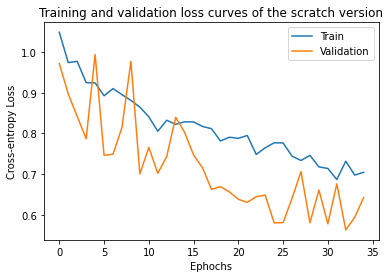

In [92]:
epo = list(range(0,35))

scratch_train_loss = [1.0491,0.9744,0.9774,0.9250,0.9245,0.8928,0.9105,0.8955,0.8813,0.8648,
                      0.8410,0.8054,0.8325,0.8226,0.8286,0.8284,0.8172,0.8118,0.7815,0.7907,0.7880,
                      0.7950,0.7484,0.7646,0.7770,0.7767,0.7441,0.7335,0.7461,0.7177,0.7139,0.6867,
                      0.7316,0.6976,0.7044]

scratch_val_loss = [0.9720,0.8971,0.8421,0.7870,0.9943,0.7461,0.7489,0.8147,0.9777,0.7005,0.7657,
                    0.7018,0.7435,0.8398,0.8025,0.7471,0.7156,0.6624,0.6690,0.6562,0.6380,0.6305,
                    0.6443,0.6483,0.5799,0.5806,0.6405,0.7060,0.5800,0.6608,0.5776,0.6760,0.5626,
                    0.5936,0.6424]

plt.title("Training and validation loss curves of the scratch version")
plt.plot(epo, scratch_train_loss, label="Train")
plt.plot(epo, scratch_val_loss, label='Validation')
plt.xlabel('Ephochs')
plt.ylabel('Cross-entropy Loss')
plt.legend()
plt.show()

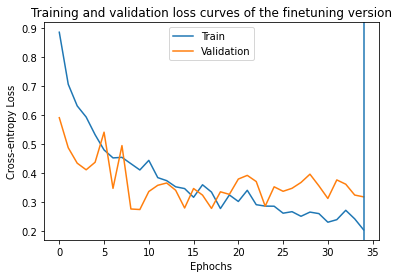

In [98]:
epo = list(range(0,35))

finetuning_train_loss = [0.8867,0.7069,0.6322,0.5937,0.5325,0.4799,0.4524,0.4543,0.4324,0.4107,
                         0.4439,0.3842,0.3737,0.3525,0.3464,0.3163,0.3595,0.3343,0.2774,0.3244,
                         0.3018,0.3404,0.2907,0.2858,0.2854,0.2613,0.2665,0.2506,0.2651,0.2599,
                         0.2301,0.2389,0.2713,0.2417,0.2035]

finetuning_val_loss = [0.5913,0.4875,0.4342,0.4113,0.4373,0.5413,0.3472,0.4949,0.2758,0.2740,
                       0.3362,0.3577,0.3657,0.3405,0.2793,0.3466,0.3238,0.2778,0.3352,0.3264,
                       0.3793,0.3920,0.3707,0.2855,0.3525,0.3370,0.3474,0.3675,0.3961,0.3558,
                       0.3122,0.3763,0.3615,0.3240,0.3177]

plt.title("Training and validation loss curves of the finetuning version")
plt.plot(epo, finetuning_train_loss, label="Train")
plt.plot(epo, finetuning_val_loss, label='Validation')
plt.axvline(x=34)
plt.xlabel('Ephochs')
plt.ylabel('Cross-entropy Loss')
plt.legend()
plt.show()                       

I choose the optimal epoch on the plot to be 34 (the number of epoches is 35). The process is that I tried 20, 25, 30, 35, 40 with different learning rates and momentum and found out that epoches=35 can ensure a set of lowest loss score and highest accuracy. At the end, I ran the model with 35 epoches, and want to save time from running the model with 40 epoches again just to label epoch=35. Although the loss curve doesn't look as good as the curve with epoch=40, it still improves the accuracy to be up to 94 and I can use the model directly for further analysis and save it.

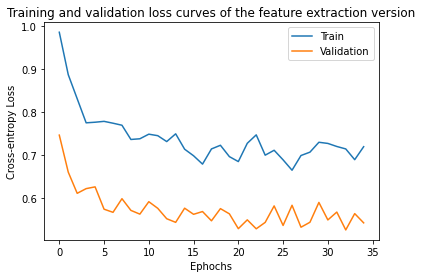

In [88]:
epo = list(range(0,35))
fe_train_loss = [0.9860,0.8874,0.8314,0.7754,0.7768,0.7788,0.7745,0.7698,0.7367,0.7383,
                 0.7490,0.7455,0.7318,0.7498,0.7141,0.6988,0.6794,0.7147,0.7232,0.6968,
                 0.6853,0.7278,0.7474,0.7002,0.7116,0.6893,0.6652,0.6994,0.7072,0.7302,
                 0.7275,0.7204,0.7147,0.6897,0.7199]

fe_val_loss = [0.7468,0.6608,0.6115,0.6224,0.6265,0.5746,0.5673,0.5990,0.5718,0.5631,
               0.5920,0.5766,0.5524,0.5440,0.5769,0.5627,0.5691,0.5476,0.5759,0.5638,
               0.5293,0.5498,0.5290,0.5439,0.5822,0.5368,0.5837,0.5327,0.5442,0.5903,
               0.5496,0.5679,0.5264,0.5643,0.5428]

plt.title("Training and validation loss curves of the feature extraction version")
plt.plot(epo, fe_train_loss, label="Train")
plt.plot(epo, fe_val_loss, label='Validation')
plt.xlabel('Ephochs')
plt.ylabel('Cross-entropy Loss')
plt.legend()
plt.show()  

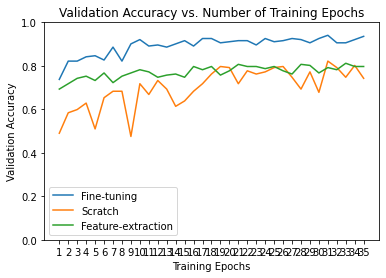

In [57]:
shist = [h.cpu().numpy() for h in hist]
fihist = [h.cpu().numpy() for h in finetuning_hist]
fehist = [h.cpu().numpy() for h in fe_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),fihist,label="Fine-tuning")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.plot(range(1,num_epochs+1),fehist,label="Feature-extraction")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

First of all, as I explained in the beginning, the fine tuning pre-trained model is the best model, which is proved here as its accuracy trend is the highest among the three, and its loss score could be down to 0.28, which is the lowest compared to the other two models.

According to the epoch plot, the best epoch to choose for the optimal fine-tuning model here would be 35, due to that I want to choose the max epoch with a really low loss score while keep a high accuracy score as much as I could. )

In [0]:
# model performance:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = finetuning_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [78]:
# per class accuracy:
print('Class:     ALB     NoF      YFT')
print(confusion_matrix.diag()/confusion_matrix.sum(1))

# confusion matrix:
confusion_matrix = pd.DataFrame(confusion_matrix, index=['ALB Actual', 'NoF Actual','YFT Actual'], columns = ['ANL Predicted', 'NoF Predicted','YFT Predicted'])
print('Confusion Matrix: \n', confusion_matrix)

Class:     ALB     NoF      YFT
tensor([0.9277, 0.8913, 0.9863])
Confusion Matrix: 
            ANL Predicted NoF Predicted YFT Predicted
ALB Actual   tensor(77.)    tensor(4.)    tensor(2.)
NoF Actual    tensor(5.)   tensor(41.)    tensor(0.)
YFT Actual    tensor(1.)    tensor(0.)   tensor(72.)


In [0]:
# save the finetuning model:
torch.save(finetuning_model.state_dict(), '/content/gdrive/My Drive/QBS108_hw4/Claire_Wang_model.pt')